In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt

In [2]:
import os, math
import cv2
import numpy as np

SATURATE_TH = 0.09
BG_HUE = 30   # read from gimp to be 60 deg

# Try to get rid of lined paper background. Successful but would hinder recognition afterwards.
# Perhaps should try fft-ifft method: https://stackoverflow.com/questions/29360025/removing-lines-from-an-image-a-notebook-for-digit-detection-python?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
def remove_nongray(imhsv):
    """ Given an NxMx3 image, return gray image where non-gray pixels are set to gray
    """
    h, s, v = imhsv[:,:,0], imhsv[:,:,1], imhsv[:,:,2]
    #print(h.min(), h.max())
    #print(s.min(), s.max())
    #print(v.min(), v.max())
    
    nongray = s > SATURATE_TH * 255
    s[nongray] = 0
    v[nongray] = 255
    return imhsv

def nongray(s):
    """ s is NxM s values in an hsv image.
    """
    return s > SATURATE_TH * 255
    

def remove_rgb(imrgb, nongray, rgb):
    """ Given an NxMx3 imrgb and a nongray mask of True/False, remove rgb from the nongray pixels.
    """
    h, s, v = imhsv[:,:,0], imhsv[:,:,1], imhsv[:,:,2]
    
    nongray = s > SATURATE_TH * 255
    s[nongray] = 0
    v[nongray] = 255
    return imhsv


def get_lines(lines_in):
    if cv2.__version__ < '3.0':
        return lines_in[0]
    return [l[0] for l in lines]

#sketch_file="../typicaldrawings-jpg/1st_floor_interior_50.jpg"
#sketch_file="../typicaldrawings-jpg/1st_floor_interior_new_wing-50.jpg"
#sketch_file="../typicaldrawings-jpg/2nd_floor_interior-50.jpg"
sketch_file="../typicaldrawings-jpg/556DFC20-147D-43DA-9DC7-8A0DD26C3A57.JPG"

basename = os.path.splitext(sketch_file)[0]
img = cv2.imread(sketch_file)

img = cv2.resize(img, (0, 0), fx=.2, fy=.2)


if 0:
    imghsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    imghsv = remove_nongray(imghsv)
    img = cv2.cvtColor(imghsv, cv2.COLOR_HSV2BGR)
    cv2.imwrite(basename + '.1-unlind.jpg', img)
    #plt.imshow(img)

black = np.zeros_like(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print("resized to", img.shape)
cv2.imwrite(basename + '.1-gray-resize.jpg', gray)

# a) adaptive thresholding
#ngedges = cv2.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 71, 2)
#ret,edges = cv2.threshold(ngedges,220,255,cv.THRESH_BINARY_INV)

# b) simple thresholding
#ret,edges = cv2.threshold(gray,80,255,cv2.THRESH_BINARY_INV)

# c) just invert the image, and threshold with TOZERO
edges = 255 - gray
ret,edges = cv2.threshold(edges,170,255,cv2.THRESH_BINARY)
#ret, edges = cv2.threshold(edges, 25, 255, cv2.THRESH_TOZERO)
#edges = cv2.adaptiveThreshold(edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 71, 2)

#plt.imshow(edges)
cv2.imwrite(basename + '.2-edges.jpg', edges)
#1/0

# LSD
lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_ADV)  #  _scale[, _sigma_scale[, _quant[, _ang_th[, _log_eps[, _density_th[, _n_bins]]]]]]]
lines, width, prec, nfa = lsd.detect(gray, )  # , _lines[, width[, prec[, nfa]
print(lines.shape, width.shape, prec.shape, nfa.shape)
print("number of line segments detected (LSD):", len(lines))
assert len(lines) > 0

def write_lines(lines, background, color=(255, 255, 255)):
    #black = np.zeros_like(img)
    for line in get_lines(lines):
        x1, y1, x2, y2 = line
        cv2.line(background, (x1, y1), (x2, y2), color, 1)
    return background

_image = lsd.drawSegments(gray, lines)
cv2.imwrite(basename + '.2-lsd-lines-on-gray.jpg', _image)

lsdimage = write_lines(lines, np.zeros_like(img[:,:,0], ))
cv2.imwrite(basename + '.2-lsd-lines-on-black.jpg', lsdimage)

use_hough = False
if use_hough:
    # Hough
    lsdimage = cv2.resize(lsdimage, (0, 0), fx=.5, fy=.5)
    cv2.imwrite(basename + '.2-lsd-lines-33.jpg', lsdimage)

    minLineLength = 30
    maxLineGap = 10
    lines = cv2.HoughLinesP(lsdimage,1,np.pi/180,threshold=50,minLineLength=minLineLength,maxLineGap=maxLineGap)
    print(len(lines), 'lines')
    if (len(lines) > 0):
        for line in get_lines(lines):
            x1, y1, x2, y2 = line
            #print(x1, y1, x2, y2, "len=", int(math.hypot(x1-x2, y1-y2)))
            cv2.line(img,(x1,y1),(x2,y2),(255,255,0),1)
            cv2.line(black, (x1, y1), (x2, y2), (255,255,0), 1)

        outfname = basename + '.3-lines.jpg'
        cv2.imwrite(outfname, black)

alllines = get_lines(lines)       
print("number of lines detected:", len(alllines))


resized to (806, 605, 3)
(622, 1, 4) (622, 1) (622, 1) (622, 1)
number of line segments detected (LSD): 622
number of lines detected: 622


<IPython.core.display.Javascript object>


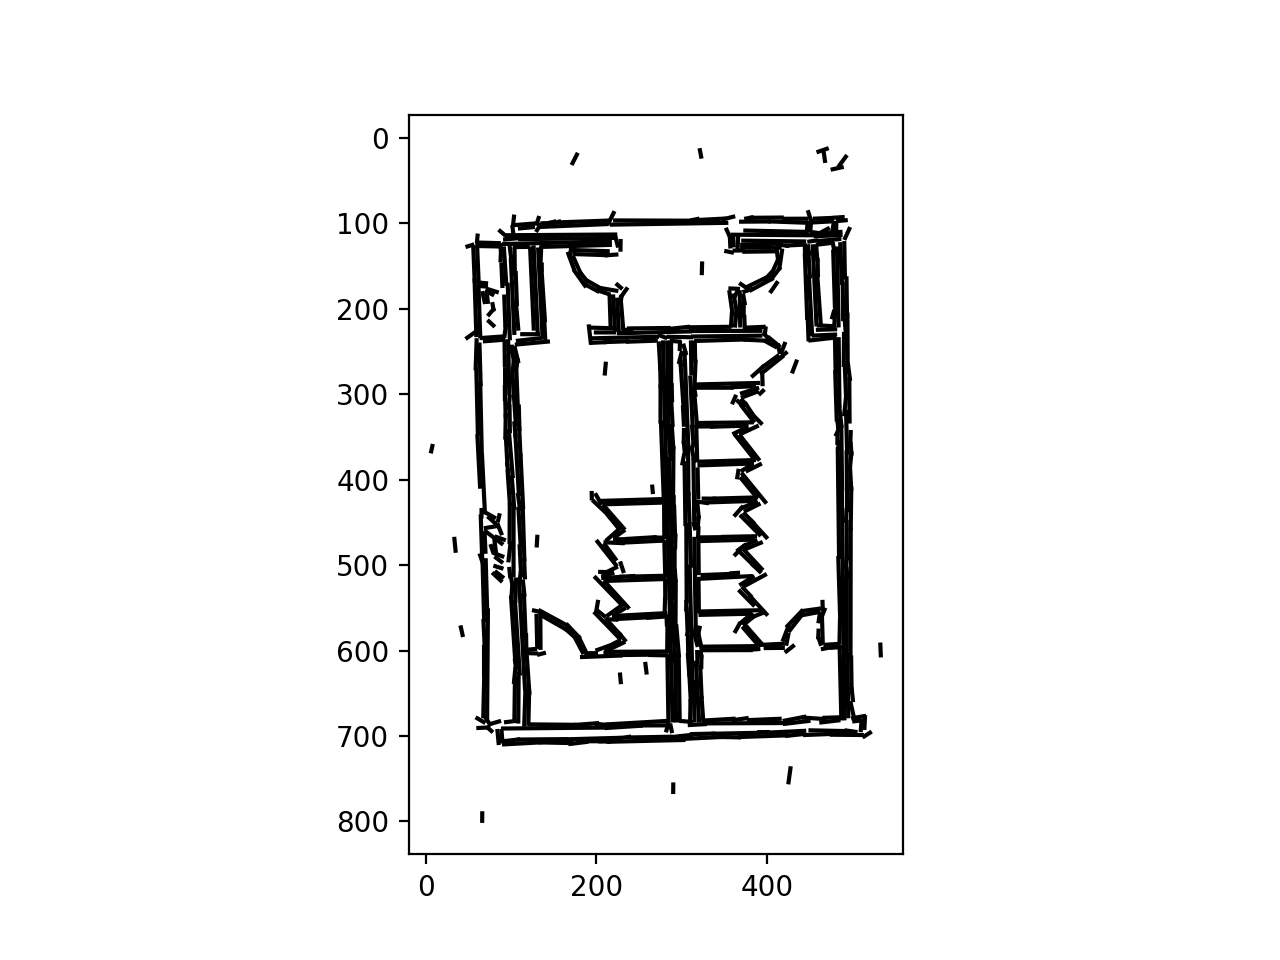

In [3]:
# plot all detected lines
def plot_line(ax, line, *args, **kwds):
    x1, y1, x2, y2 = line
    ax.plot((x1, x2), (y1, y2), *args, **kwds)
    
def plot_lines(ax, lines, *args, **kwds):
    for line in lines:
        plot_line(ax, line, *args, **kwds)
    ax.axis('image')

fig, ax = plt.subplots()
plot_lines(ax, alllines, '-k')
ax.invert_yaxis()

In [502]:
from rtree import index
from numpy.linalg import norm

def pt2box(pt):
    v = pt.ravel()
    box = (v[0], v[1], v[0], v[1])
    return box

def boxaroundpoint(pt, d):
    r = d / 2
    box = (pt[0] - r, pt[1] - r, pt[0] + r, pt[1] + r)    # left, bottom, right, top
    return box

def length(seg):
    return norm(vector(seg))

def vector(seg):
    ret = np.array((seg[2] - seg[0], seg[3] - seg[1]))
    return ret

def dist(line, xy):
    """ line: (x1, y1, x2, y2)
        xy:   (x, y)
        -> distance between xy and line, can be positive or negative
        
        >> dist((0, 0, 2, 0), (1, 1))
        1.0
        
        for the same line, dist from it can be positive or negative
        if xys are located in both side of the the line
    """
    line, xy = np.asarray(line), np.asarray(xy)
    p1, p2 = line[:2], line[2:]
    return np.cross(p2 - p1, xy - p1) / norm(p2 - p1)


#https://stackoverflow.com/questions/41855695/sorting-list-of-two-dimensional-coordinates-by-clockwise-angle-using-python
from scipy.spatial import distance

# does NOT work for me
def sortpts_clockwise(A):
    # Sort A based on Y(col-2) coordinates
    sortedAc2 = A[np.argsort(A[:,1]),:]

    # Get top two and bottom two points
    top2 = sortedAc2[0:2,:]
    bottom2 = sortedAc2[2:,:]

    # Sort top2 points to have the first row as the top-left one
    sortedtop2c1 = top2[np.argsort(top2[:,0]),:]
    top_left = sortedtop2c1[0,:]

    # Use top left point as pivot & calculate sq-euclidean dist against
    # bottom2 points & thus get bottom-right, bottom-left sequentially
    sqdists = distance.cdist(top_left[None], bottom2, 'sqeuclidean')
    rest2 = bottom2[np.argsort(np.max(sqdists,0))[::-1],:]

    # Concatenate all these points for the final output
    return np.concatenate((sortedtop2c1,rest2),axis =0)

#https://gist.github.com/arthur-e/5cf52962341310f438e96c1f3c3398b8
from functools import reduce
def convex_hull_graham(points):
    '''
    Returns points on convex hull in CCW order according to Graham's scan algorithm. 
    By Tom Switzer <thomas.switzer@gmail.com>.
    '''
    TURN_LEFT, TURN_RIGHT, TURN_NONE = (1, -1, 0)

    def cmp(a, b):
        #print('a=', a, 'b=', b, 'type(a)=', type(a), 'type(b)=', type(b))
        a = float(a)
        return (a > b) - (a < b)

    def turn(p, q, r):
        return cmp((q[0] - p[0])*(r[1] - p[1]) - (r[0] - p[0])*(q[1] - p[1]), 0)

    def _keep_left(hull, r):
        while len(hull) > 1 and turn(hull[-2], hull[-1], r) != TURN_LEFT:
            hull.pop()
        if not len(hull) or hull[-1] != r:
            hull.append(r)
        return hull

    points = sorted(points)
    l = reduce(_keep_left, points, [])
    u = reduce(_keep_left, reversed(points), [])
    return l.extend(u[i] for i in range(1, len(u) - 1)) or l

if 0:
    # lineidx is index into alllines, obj is 0/1.
    epindex = index.Index()
    for lineidx, line in enumerate(alllines):
        epindex.insert(lineidx, pt2box(line[:2]), obj=0)
        epindex.insert(lineidx, pt2box(line[2:]), obj=1)


line0 = alllines[0]
line00 = line0[:2]
pt2box(line00)

ids = [id for id in epindex.intersection(boxaroundpoint(line00, 15), objects=True)]
print(ids[0], ids[0].id, ids[0].object)

# print(epindex.intersection(boxaroundpoint(line00, 15), objects=True)) # is a generator
print('length of alllines:', len(alllines))


A = np.array([[ 281.,  147.],
       [ 213.,  170.],
       [ 239.,  242.],
       [ 307.,  219.]], dtype=np.float32)
print(A.shape)

sortpts_clockwise(A)
#Out[86]: 
#array([[ 213.,  170.],
#       [ 281.,  147.],
#       [ 307.,  219.],
#       [ 239.,  242.]], dtype=float32)
print([(pt[0], pt[1]) for pt in A])
convex_hull_graham([tuple(pt) for pt in A])


<rtree.index.Item object at 0x63e0d7728> 0 0
length of alllines: 622
(4, 2)
[(281.0, 147.0), (213.0, 170.0), (239.0, 242.0), (307.0, 219.0)]


[(213.0, 170.0), (281.0, 147.0), (307.0, 219.0), (239.0, 242.0)]

In [269]:
False - True

-1

In [487]:
import warnings

MAX_BOX_SIZE = 20
LINE_THICKNESS = 2

def length(seg):
    return norm(vector(seg))

def vector(seg):
    return np.array((seg[2] - seg[0], seg[3] - seg[1]))

class Curve:
    
    def __init__(self, lineindex, all_lines):
        """ lineindex: init line index
        """
        self.lineindices = [lineindex]
        self.all_lines = all_lines
        self.hotends = [0, 1]
        initline = all_lines[lineindex]
        self.nodes = [initline[:2], initline[2:]]
    
    def grow(self, spatial_index, part_of_a_curve):
        """ uses alllines, spatial_index
        """
        all_lines = self.all_lines
        
        # new lines added from last call
        indices = self.lineindices[- len(self.hotends) :]  #; print("indices=", indices)
        endlines = [all_lines[idx] for idx in indices]
        
        # we always check both ends for new lines
        
        endlines += endlines
        self.hotends += [zeroorone ^ 1 for zeroorone in self.hotends]
        hotends = [line[:2] if lineend == 0 else line[2:]
                   for line, lineend in zip(endlines, self.hotends)] 
            
        #print('indices:', indices, 'self.hotends:', self.hotends, 'hotends:', hotends)
        self.hotends.clear()
        
        d = 10   # a good value may be related to LSD parameters
        searchboxes = [boxaroundpoint(e, d) for e in hotends]
        for endline, box in zip(endlines, searchboxes):
            nearbyends = spatial_index.intersection(box, objects=True)
            nearbyends = [e for e in nearbyends
                          if not part_of_a_curve[e.id] 
                          and e.id not in self.lineindices]  # end is on a different line seg
        
            nearbyendsids = [e.id for e in nearbyends]
            #print('nearbyendsids:', nearbyendsids)
                
            # only those coherent to current curve
            newends = [e for e in nearbyends if self.is_coherent(endline, all_lines[e.id])]
            
            for e in newends:           
                lineseg = all_lines[e.id]
                if e.id in self.lineindices:
                    warnings.warn("line {} is already in self.lineindices".format(e.id))
                    continue
                self.lineindices.append(e.id)
                self.hotends.append({0:1, 1:0}[e.object])
                part_of_a_curve[e.id] = True
                print(" {}:{},".format(e.id, e.object), end=' ')
            #print('self.hotends:', self.hotends)

        # TODO: remove tail recursion
        if len(self.hotends) > 0:
            #print()
            #print('self.hotends=', self.hotends)
            #print('indices=', self.lineindices[- len(self.hotends) :])
            #print()
            self.grow(spatial_index, part_of_a_curve)
            
    def convexhull(self):
        """ -> convex hull of all the end points of the line segments. array of Nx2
        """
        lines = [self.all_lines[idx] for idx in self.lineindices]
        if 0:
            xs = [x for line in lines for x in line[0::2]]
            ys = [y for line in lines for y in line[1::2]]
            points = np.array((xs, ys)).T   # Nx2
        
            xymin, xymax = points.min(0), points.max(0)
            xextremes = [xymin[0], xymax[0]]
            yextremes = [xymin[1], xymax[1]]
            extpts = np.array([pt for pt in points if pt[0] in xextremes or pt[1] in yextremes])
        
        # triangle is not welcome, need a convex
        allpoints = [pt for line in lines for pt in (tuple(line[2:]), tuple(line[:2])) ]
        convexhull = convex_hull_graham(allpoints)
        return np.array(convexhull + convexhull[:1])   # return a closed curve
                         
    def borders(self, lines):
        extpts = self.extreme_points()
        # extpts should resolve to 4 points of a rectangle area
        ls0, ls1 = self.project(extpts)
        #print("extreme pts:", extpts)
        return ls0, ls1                 
        
    def project(self, xy):
        """ return N points that is the projection of xy on to .line0 and .line1
            xy - an Nx2 array or (2,) array
        """
        pj0 = self._project(xy, self.line0)  # several points on .line0
        #print("pj to line0:\n", pj0)
        pj0 = pj0[pj0[:,0].argsort()]  # sort according to x
        #print("pj to line0 (sorted):\n", pj0)

        pt0, pt1 = pj0[0], pj0[-1]
        lineseg0 = (pt0[0], pt0[1], pt1[0], pt1[1])
        
        pj1 = self._project(xy, self.line1)
        pj1 = pj1[pj1[:,0].argsort()]  # sort according to x

        #print("pj to line1:\n", pj1)
        pt0, pt1 = pj1[0], pj1[-1]
        lineseg1 = (pt0[0], pt0[1], pt1[0], pt1[1])
        return lineseg0, lineseg1
    
    @staticmethod
    def _project(xy, line):
        """
        """
        pts = np.array(xy)
        x1, y1, x2, y2 = line
        p1, p2 = np.array((x1, y1)), np.array((x2, y2))
        
        b = p2 - p1
        b_hat = b / norm(b)
        
        p = pts - p1      
        #print("p=", p)
        if len(p.shape) == 1:
            p = p[np.newaxis, ...]
        
        #print("p=", p, "p.shape =", p.shape)
        res = np.array([pt.dot(b_hat) * b_hat + p1 for pt in p])
        #print(res.shape)
        return res
    
    @staticmethod
    def is_coherent(line1, line0):
        """
        """
        vline0, vline1 = vector(line0), vector(line1)
        result = np.cross(vline0, vline1)  
        #print("cross product=", result)
        abberation = abs(result) / norm(vline0)   # line1's abberation from line0
        sine = abberation / norm(vline1)
        if 0:
            print("is_parallel abberation={} sine={}".format(abberation, sine))
        #return sine < 0.5  # .5 sine(pi/6) == 1/2
        return sine < 0.1 or (sine < 0.5 and abberation < 15)  
    
    
    
alllines = get_lines(lines)
line = alllines[0]
print('len of alllines:', len(alllines))
       

len of alllines: 622


In [531]:
import cmath
from polysimplify import VWSimplifier

class Wall:
    
    def __init__(self, curve):
        self.curve = curve
        self.handle = None  # (x,y) of the center point
        self.angle = None   # angle of the wall
        envelope = self.simplify()
        if not self.recognize(envelope):
            raise RuntimeError("Curve does not seem a wall, no two parallel borders found.")

    
    @staticmethod
    def is_parallel(v0, v1):
        """
        """
        sine = np.cross(v0/norm(v0), v1/norm(v1))
        print('sine=', sine)
        return sine < 0.05
        
    def simplify(self): # , threshold=500):
        chull = self.curve.convexhull()
        assert np.allclose(chull[0], chull[-1]), "convext hull is not closed."
        
        self.border = border = VWSimplifier(chull)
        
        #pts = border.from_threshold(threshold)      
        pts = border.from_number(4 + 1)   # close curve has 1st and last point identical, they are not removed
        return pts
    
    def recognize(self, envelope):
        vlines = envelope[:-1] - envelope[1:]
        norms = norm(vlines, axis=1)
        norms_sorted_order = norms.argsort()[::-1]
        vlines_sorted = vlines[norms_sorted_order]
        
        if self.is_parallel(vlines_sorted[0], vlines_sorted[1]):
            print("envelope=", envelope, "norms_sorted_order=", norms_sorted_order)
            idx0, idx1 = norms_sorted_order[0], norms_sorted_order[1]
            self.handle = envelope.mean(axis=0)
            v = vlines_sorted[:2].mean(axis=0)
            cv = v[0] + v[1] * 1j
            self.angle = cmath.phase(cv)
            return True  # usual wall
        else:
            return False
     
    
print(sketch.curves[0])
if 'sketch' in dir():
    w = Wall(sketch.curves[0])
    res = w.simplify()
    chull = w.curve.convexhull()   # return a closed convex hull
    print(w.handle, w.angle)
    plt.plot(w.handle[0], w.handle[1], 'ro')  # start
    plt.plot(res[:, 0], res[:, 1], "g+")

sine= 0.0042273067
envelope= [[ 87.33249  125.5708  ]
 [108.181725 261.20633 ]
 [121.42333  649.4066  ]
 [103.91705  680.63586 ]
 [ 87.33249  125.5708  ]] norms_sorted_order= [3 1 0 2]
[inf, inf, 5117.5254, 5117.5254, 3148.8232, 355.87646, 299.57166, 254.83362, 21.793602, 16.010742, 12.285156, 0.2855835]
simplied:
 [[ 87.33249  125.5708  ]
 [108.181725 261.20633 ]
 [121.42333  649.4066  ]
 [103.91705  680.63586 ]
 [ 87.33249  125.5708  ]]
[101.63742 368.4781 ] 1.550765080671333


In [522]:
a = np.array( [[ 87.33249,  125.5708  ],
 [108.181725, 261.20633 ],
 [121.42333,  649.4066  ],
 [103.91705,  680.63586 ],
 [ 87.33249,  125.5708  ]])

start = a[:-1]; end = a[1:]
diff = end - start
print(diff)

norms = norm(diff, axis=1)
print(norms)
print(norms.argsort()[::-1])
diff[norms.argsort()[::-1]]

a.mean(axis=0)

[[  20.849235  135.63553 ]
 [  13.241605  388.20027 ]
 [ -17.50628    31.22926 ]
 [ -16.58456  -555.06506 ]]
[137.22859614 388.42604152  35.80134801 555.31276634]
[3 1 0 2]


array([101.637417, 368.478078])

<IPython.core.display.Javascript object>


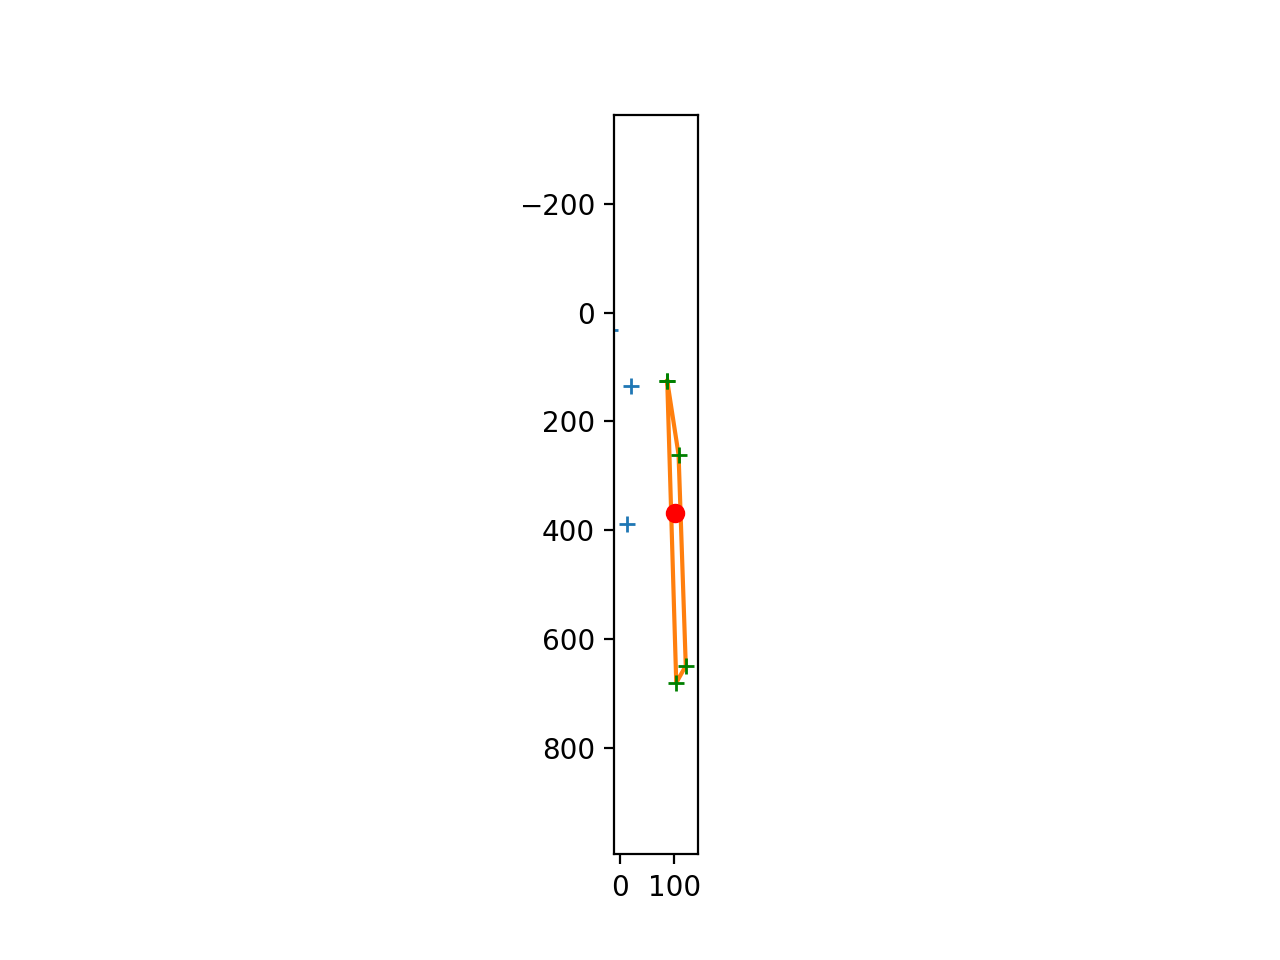

array(-0.00422731)

In [530]:
fig, ax = plt.subplots()
ax.invert_yaxis()
ax.plot(diff[:, 0], diff[:, 1], '+')
ax.plot(a[:, 0], a[:, 1], '-')
ax.axis('image')

np.cross(diff[1]/norm(diff[1]), diff[3]/norm(diff[3]))

In [360]:
lg = Curve(20, alllines)
lg.grow(epindex, np.zeros(len(alllines), dtype=bool))
lg.lineindices



 29:1,  21:0,  30:1,  17:0,  25:1,  28:1,  19:1,  18:0,  35:0,  14:1,  8:0, 

/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 14 is already in self.lineindices


[20, 29, 21, 30, 17, 25, 28, 19, 18, 35, 14, 8]

In [376]:
class Sketch:
    
    def __init__(self, line_segments):
        self.line_segments = line_segments
        
        # lineidx is index into alllines, obj is 0/1.
        self.spatial_index = epindex = index.Index()
        for lineidx, line in enumerate(line_segments):
            epindex.insert(lineidx, pt2box(line[:2]), obj=0)
            epindex.insert(lineidx, pt2box(line[2:]), obj=1)
        
        self.part_of_a_curve = np.zeros(len(self.line_segments), dtype=bool)
        self.curves = []
        
    
    def refresh_curves(self):
        self.part_of_a_curve = np.zeros(len(self.line_segments), dtype=bool)
        self.curves.clear()
        
        for idx in range(len(self.line_segments) - 1, -1, -1):
    
            if self.part_of_a_curve[idx]:
                continue
        
            curve = Curve(idx, self.line_segments)
            curve.grow(self.spatial_index, self.part_of_a_curve)
            self.curves.append(curve)
            print("curve created {}".format(curve.lineindices))
    
            #for i in curve.lineindices:
            #    part_of_a_curve[i] = True
  

In [362]:
import matplotlib.patches as patches

def plot_lines_list(ax, lines, *args, **kwds):
    for idx, line in enumerate(lines):
        plot_line(ax, line, *args, **kwds)
        start = line[:2]
        ax.text(start[0], start[1], '%d' % idx)
    ax.axis('image')
    
def plot_line_group(ax, lines, *args, **kwds):
    plot_lines(ax, lines, '-k', alpha=0.7)
    plot_line(ax, lines[0], '-r')
    ax.axis('image')
    
def plot_line_sublist(ax, linelist, indices, *args, **kwds):
    with_text = kwds.pop('with_text', True)
    for idx in indices:
        line = linelist[idx]
        plot_line(ax, line, *args, **kwds)
        start = line[:2]
        if with_text:
            ax.text(start[0], start[1], '%d' % idx)
    plot_line(ax, linelist[indices[0]], '-r')
    ax.axis('image')

def plot_box(ax, box, *args, **kwds):
    # a box is (left, bottom, right, top)
    rect = patches.Rectangle(
        (box[0], box[1]),    # bottom, left of box, exchanged as in image
        box[3] - box[1],     # width
        box[2] - box[0],     # height
        fill=False     # remove background
    )
    ax.add_patch(rect)

if 0:
    linesthis = [alllines[i] for i in lg.lineindices]
    print(len(linesthis), "lines")

    fig, ax = plt.subplots()
    plot_lines(ax, alllines, '-k', alpha=0.1)
    plot_lines_list(ax, linesthis, '-k')
    ax.invert_yaxis()
    ax.axis('image')


In [363]:
print(alllines[612])
print(alllines[614])


[ 88.22394  706.49664  108.249695 704.2236  ]
[204.36963 706.21936 188.1268  706.2652 ]


In [488]:
sketch = Sketch(alllines)
sketch.refresh_curves()
sketch.curves.sort(reverse=True, key=lambda curve: len(curve.lineindices))

print("{} curves formed from {} line segments".format(len(sketch.curves), len(alllines)))
for idx, curve in enumerate(sketch.curves):
    print(idx, ":", curve.lineindices)

nlines = [len(c.lineindices) for c in sketch.curves]
print("total", sum(nlines))

curve created [621]
curve created [620]
curve created [619]
 616:1,  617:0,  614:1,  612:0,  615:1,  610:0,  613:1,  611:0,  608:1,  602:0,  609:1,  607:0,  606:1,  605:0,  603:1,  598:0,  594:1,  600:1,  599:0,  593:1,  604:1, curve created [618, 616, 617, 614, 612, 615, 610, 613, 611, 608, 602, 609, 607, 606, 605, 603, 598, 594, 600, 599, 593, 604]
curve created [601]
 596:1, curve created [597, 596]
 592:1, curve created [595, 592]
 572:1,  571:0, curve created [591, 572, 571]
 577:0, curve created [590, 577]
 586:1,  539:0,  206:1,  207:1,  212:1,  545:0,  290:1,  237:1,  540:1,  541:0,  452:0,  208:0,  311:1,  249:1,  394:0,  247:0,  492:1,  275:1,  262:0,  443:1,  280:0,  422:1,  303:0,  402:1,  337:0,  380:1,  350:0, curve created [589, 586, 539, 206, 207, 212, 545, 290, 237, 540, 541, 452, 208, 311, 249, 394, 247, 492, 275, 262, 443, 280, 422, 303, 402, 337, 380, 350]
 574:0,  581:1,  587:1,  578:1,  585:1,  580:1, curve created [588, 574, 581, 587, 578, 585, 580]
 570:1, curve

/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 540 is already in self.lineindices
/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 67 is already in self.lineindices
/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 209 is already in self.lineindices
/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 70 is already in self.lineindices


curve created [524, 523, 514, 512, 518]
 513:1,  520:0, curve created [521, 513, 520]
curve created [519]
curve created [516]
 484:1,  500:0,  473:1,  468:1,  456:1, curve created [509, 484, 500, 473, 468, 456]
 489:1,  506:0,  464:1,  478:0,  498:0,  458:1, curve created [507, 489, 506, 464, 478, 498, 458]
 493:0,  467:0,  480:1, curve created [505, 493, 467, 480]
 495:0,  496:1,  502:0, curve created [504, 495, 496, 502]
 472:0,  485:1,  465:0, curve created [501, 472, 485, 465]
curve created [497]
curve created [494]
 483:0, curve created [491, 483]
curve created [490]
 476:0,  471:1,  479:0,  460:1,  470:0, curve created [488, 476, 471, 479, 460, 470]
 408:0,  305:0,  297:0,  291:0,  286:0, curve created [486, 408, 305, 297, 291, 286]
 475:1,  466:0,  481:0, curve created [482, 475, 466, 481]
 474:1, curve created [477, 474]
 461:1, curve created [469, 461]
 457:1, curve created [459, 457]
curve created [454]
 440:0, curve created [451, 440]
 446:1,  447:1, curve created [449, 446,

/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 421 is already in self.lineindices
/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 261 is already in self.lineindices
/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 98 is already in self.lineindices
/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 43 is already in self.lineindices


 134:0,  127:0,  122:0, curve created [137, 134, 127, 122]
 131:0,  118:1,  125:0,  114:1,  111:0,  101:1,  99:0,  84:0, curve created [135, 131, 118, 125, 114, 111, 101, 99, 84]
 119:1,  110:1,  92:1,  102:0,  112:1,  117:1, curve created [133, 119, 110, 92, 102, 112, 117]
curve created [132]
curve created [129]
curve created [124]
curve created [123]
 105:1,  77:1,  76:1, curve created [115, 105, 77, 76]
curve created [106]
 73:0, curve created [104, 73]
 85:1,  96:0, curve created [97, 85, 96]
curve created [93]
 86:1,  74:0,  90:1,  60:0,  66:1,  55:0,  62:1, curve created [91, 86, 74, 90, 60, 66, 55, 62]
 80:0, curve created [83, 80]
curve created [71]
 58:1, curve created [69, 58]
 57:1, curve created [65, 57]
curve created [64]
 54:0,  56:1,  46:0,  43:1,  38:0,  45:0,  41:1, curve created [61, 54, 56, 46, 43, 38, 45, 41]
 50:0, curve created [59, 50]
 51:1,  40:0,  52:1, curve created [53, 51, 40, 52]
 44:1,  48:0, curve created [49, 44, 48]
curve created [47]
curve created [42

/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 20 is already in self.lineindices
/Users/ywei/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: UserWarning: line 14 is already in self.lineindices


<IPython.core.display.Javascript object>


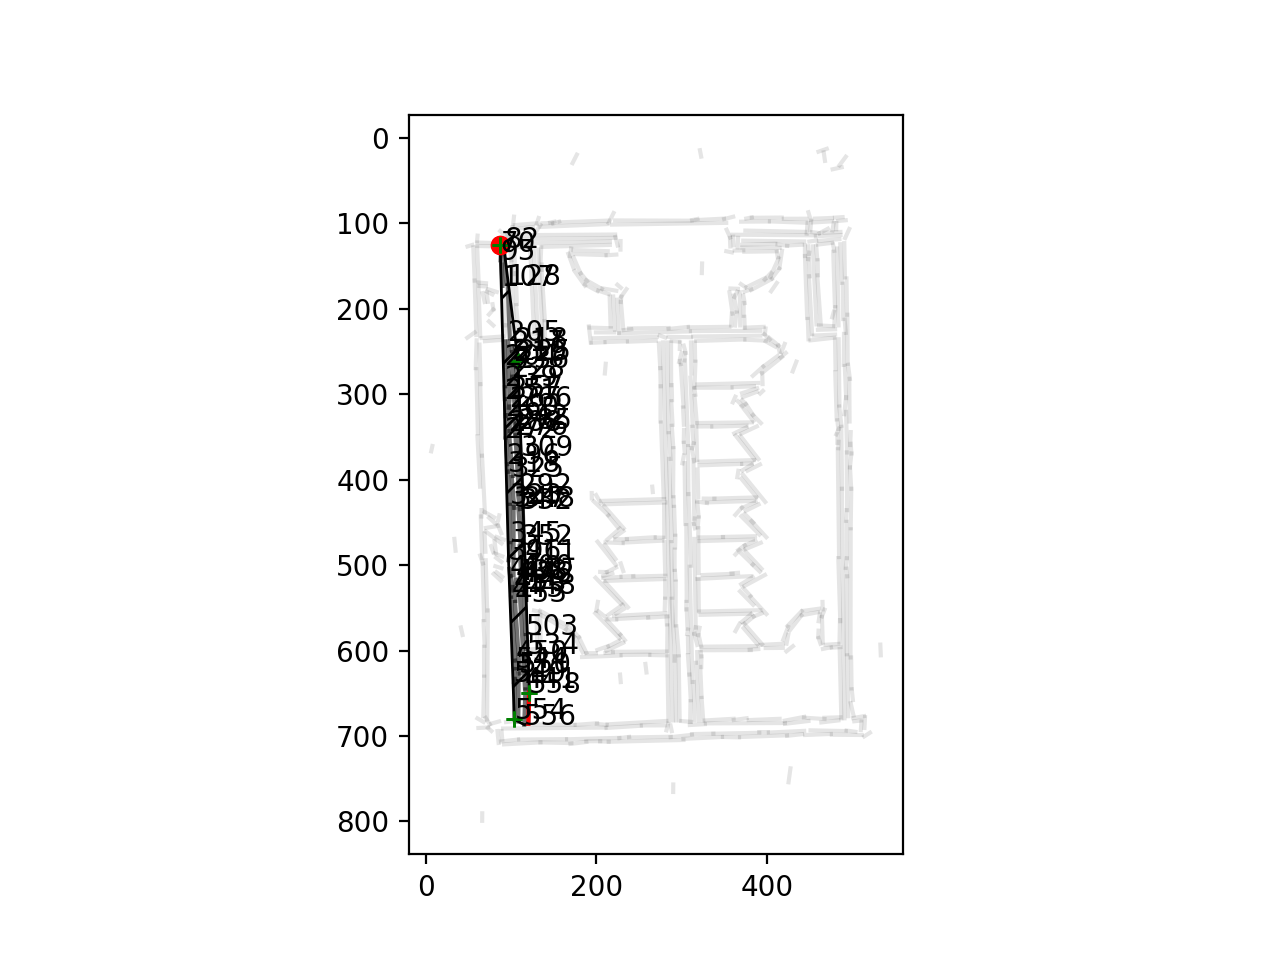

idx:0 lineindices:[558, 441, 556, 534, 438, 442, 445, 453, 448, 426, 411, 433, 550, 503, 400, 348, 450, 347, 418, 554, 352, 309, 332, 544, 323, 345, 325, 549, 285, 292, 318, 396, 288, 266, 276, 296, 265, 236, 242, 272, 257, 225, 228, 260, 205, 219, 218, 251, 204, 128, 217, 239, 82, 70, 107, 95]
curve.convex_hull(): [[ 87.33249  125.5708  ]
 [ 91.66435  129.30656 ]
 [108.181725 261.20633 ]
 [114.08416  431.82806 ]
 [121.42333  649.4066  ]
 [120.29339  685.6468  ]
 [115.45391  686.8276  ]
 [108.48357  683.13617 ]
 [103.91705  680.63586 ]
 [ 97.07021  494.39716 ]
 [ 87.73168  143.21376 ]
 [ 87.33249  125.5708  ]]


In [449]:
fig, ax = plt.subplots()
ax.invert_yaxis()
plot_lines(ax, alllines, '-k', alpha=0.1)

curves = sketch.curves
idx = 0

print('idx:{} lineindices:{}'.format(idx, sketch.curves[idx].lineindices))
plot_line_sublist(ax, alllines, sketch.curves[idx].lineindices, '-k', alpha=0.5)

print('curve.convex_hull():', curves[idx].convexhull())
ax.add_patch(patches.Polygon(curves[idx].convexhull(), closed=True, fill=False, hatch='/'))
#for curve in curves:
#    if len(curve.lineindices) > 1:
#        plot_line_group(ax, [alllines[i] for i in curve.lineindices])

In [382]:
epts = sketch.curves[2].convexhull()
print(epts.shape)
print(epts)
plt.plot(epts[:, 0], epts[:, 1], "r+")


(10, 2)
[[476.9774  124.35653]
 [490.16425 123.11099]
 [492.7228  164.34644]
 [496.6745  282.05786]
 [498.48862 369.348  ]
 [500.9397  676.11835]
 [490.35873 679.37805]
 [486.6533  679.40985]
 [484.7266  598.11664]
 [478.4184  219.31613]]


In [116]:
# debugging endpoints
box = boxaroundpoint(alllines[206][:2], 10)
#print(box)
plot_box(ax, box)

nearbyends = sketch.spatial_index.intersection(box, objects=True)
for e in nearbyends:
    print(e.id, e.object)

206 0
207 1
212 1


<IPython.core.display.Javascript object>


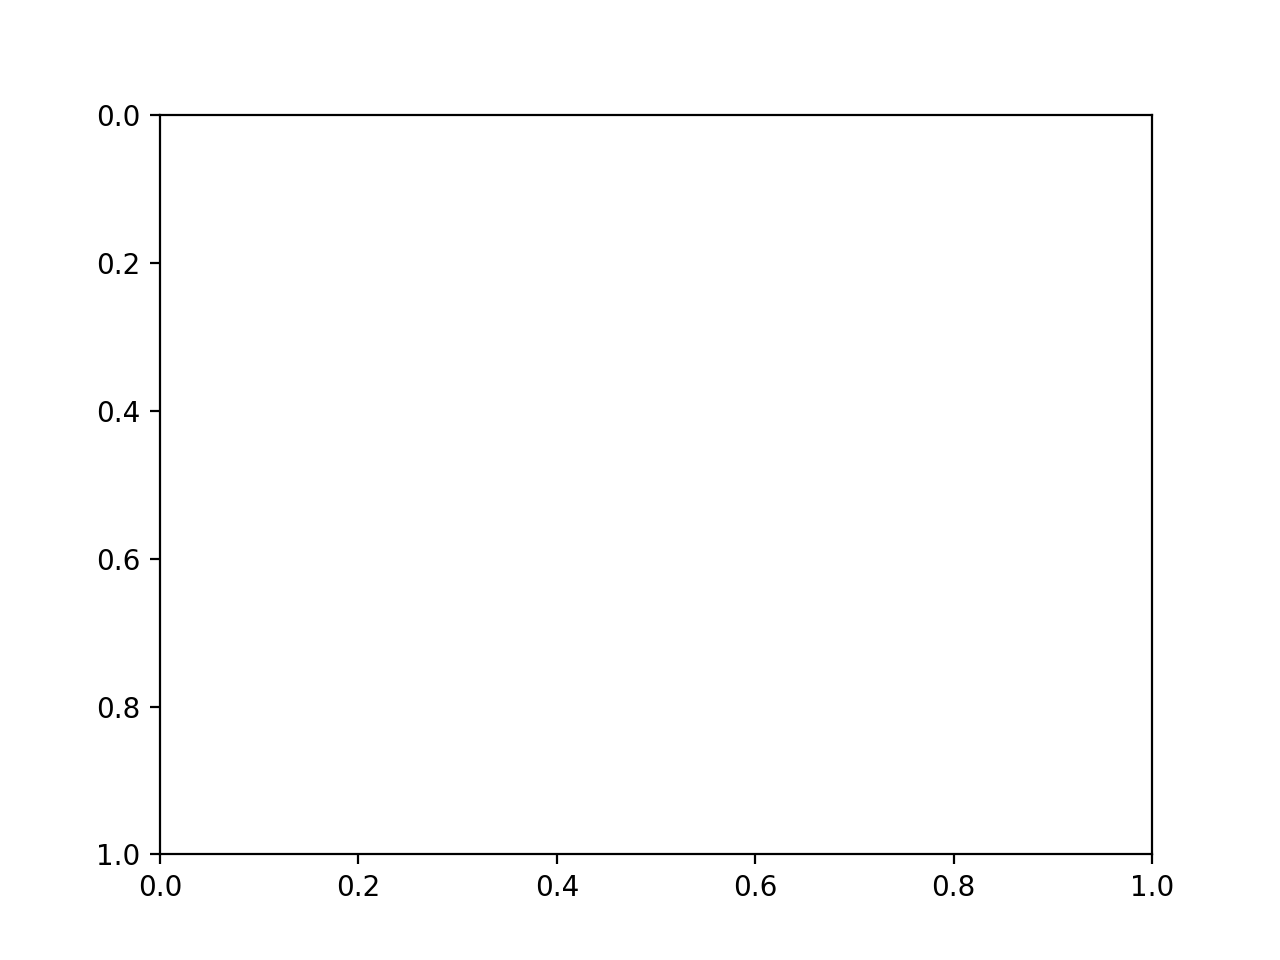

In [230]:
fig, ax = plt.subplots()
ax.invert_yaxis()

[[476.9774  124.35653]
 [490.16425 123.11099]
 [492.7228  164.34644]
 [496.6745  282.05786]
 [498.48862 369.348  ]
 [500.9397  676.11835]
 [490.35873 679.37805]
 [486.6533  679.40985]
 [484.7266  598.11664]
 [478.4184  219.31613]]


<IPython.core.display.Javascript object>


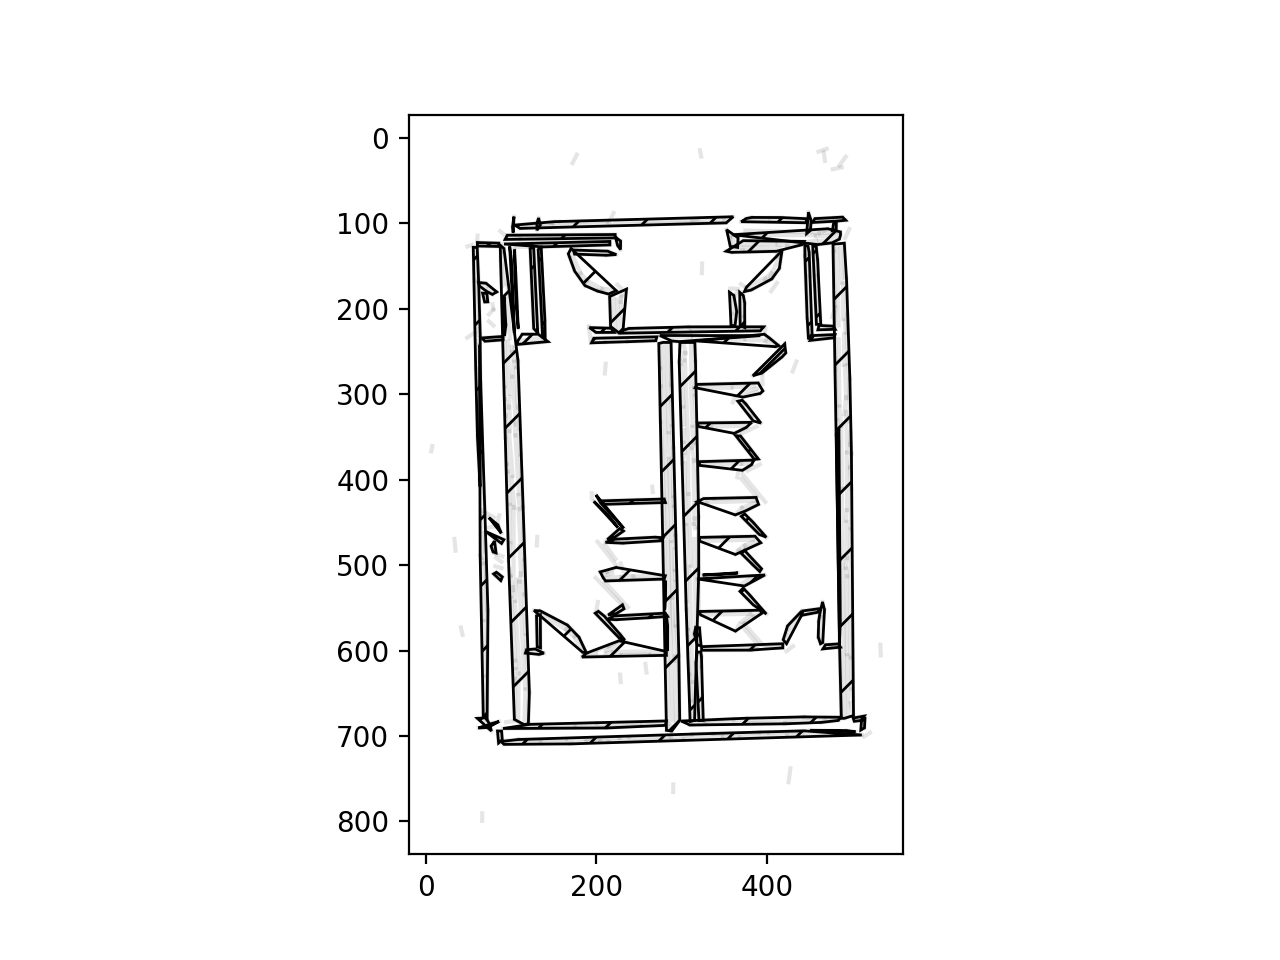

(-19.785618233680726, 559.1903819322586, 838.7176486492157, -26.71722807884217)

In [384]:
# sort walls according to confidence, as the total number of the line segments
sketch.curves.sort(reverse=True, key=lambda curve: len(curve.lineindices))
print(sketch.curves[2].convexhull())

fig, ax = plt.subplots()
ax.invert_yaxis()

plot_lines(ax, alllines, '-k', alpha=0.1)

for curve in sketch.curves:
    if len(curve.lineindices) > 1:
        # plot all segments
        #plot_line_sublist(ax, alllines, curve.lineindices, '-k', alpha=0.5, with_text=False)
        
        poly = patches.Polygon(curve.convexhull(), closed=True, fill=False, hatch='/')
        ax.add_patch(poly)

ax.axis('image')
        
        

In [372]:
print(sketch.curves[4].extreme_points())

[[ 88.22394  706.49664 ]
 [108.249695 704.2236  ]
 [311.86914  697.8543  ]
 [390.62326  695.5099  ]
 [443.17096  694.0752  ]
 [510.60577  698.9311  ]
 [169.52254  709.3409  ]
 [ 91.83514  709.89685 ]]


<IPython.core.display.Javascript object>


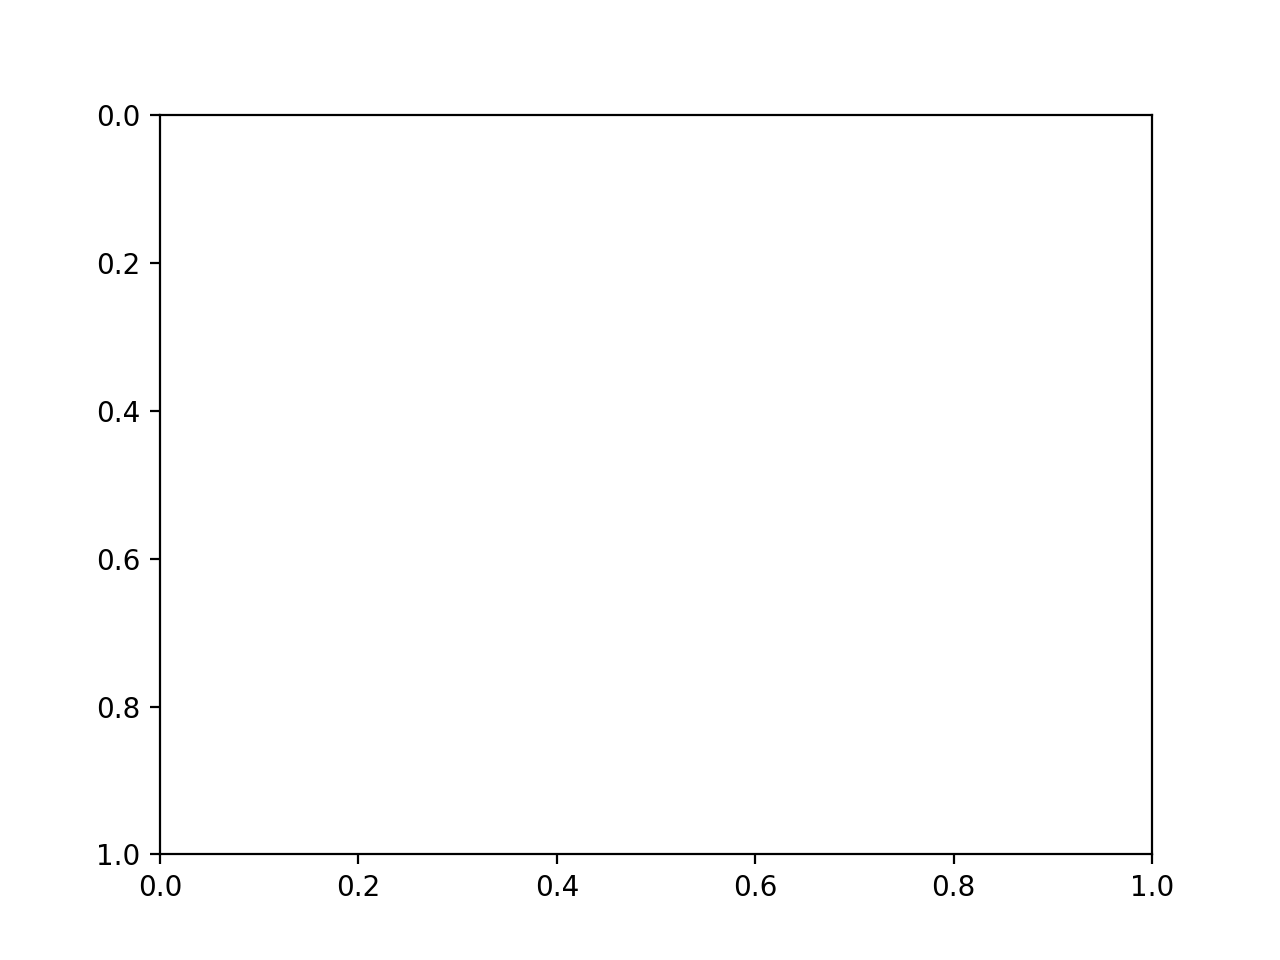

In [230]:
fig, ax = plt.subplots()
ax.invert_yaxis()